In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regular expressions
import re

# LightGBM
import lightgbm as lgb

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("data.csv")
pd.set_option('display.max_columns', 100)
df = df.drop(['employees_created'], axis=1)
df = df.drop(['employee_id'], axis=1)
df["age"] = df["age"].fillna(df["age"].mean())
df["influx_route_midium"] = df["influx_route_midium"].fillna('null')
df["influx_route_small"] = df["influx_route_small"].fillna('null')
df_a = df.copy()
df_b = pd.get_dummies(df_a['influx_route_big'], drop_first = True)
df_c = pd.get_dummies(df_a['influx_route_midium'], drop_first = True)
df_d= pd.get_dummies(df_a['influx_route_small'], drop_first = True)
df_e= pd.get_dummies(df_a['device'], drop_first = True)

df = pd.concat([df, df_b, df_c, df_d, df_e], axis=1)
df = df.drop(['influx_route_big'], axis=1)
df = df.drop(['influx_route_midium'], axis=1)
df = df.drop(['influx_route_small'], axis=1)
df = df.drop(['device'], axis=1)

In [2]:
df.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,DSP,SEO,twitter広告,その他,アフィリエイト,メルマガ,リスティング,提携媒体,GDN,GoogleMap,Google検索,KWターゲティング,LINE,TOP埋め込みEF,YDN,Yahoo検索,docomo,null,useful下部固定,webもり,アクセストレード,アフィリエイトB,キャリアパーク,フォロワーターゲティング,プレスコ,プロモツイート,メディパートナー,リマーケティング,...,infeed_remarketing,infeed_インタレストマッチ,infeed_ターゲティング,null,こだわり軸,セミナー,ターゲティング,ターゲティング_remarketing,ターゲティング_インタレストマッチ,ハローワーク軸,フォロワーターゲティング,フリーター軸,ミドルワード軸,メルマガ_登録半年以内_アプローチ+面談日程連絡待ち_求人紹介_転職無し,メルマガ_登録半年以内_アプローチ_ハタラクティブ魅力付け,メルマガ_登録半年以内_面談済み_就活ノウハウ_就活準備,メルマガ_登録半年以内_面談済み_求人紹介_残業無し推し,メルマガ_登録半年以前_面談済み_就活ノウハウ_就活全体,メルマガ_登録半年以前_面談済み_求人紹介_転職無し,メルマガ_面談済み_応募意思あり_CCテキストよびかけ,リターケティング,リマーケティング,友達紹介カード,地域軸,地域軸_未経験,大卒軸,就職軸_学歴KW軸,属性軸,属性軸_フリーター軸,属性軸_大卒軸,属性軸_既卒軸,属性軸_第二新卒軸,属性軸_高卒軸,手動プレースメント,指名検索軸,支援軸,既卒軸,正社員軸,相談軸,第二新卒軸,職種軸,自動プレースメント,自動メール_登録10日後経過面談未予約_カウンセラー紹介,自動メール_登録7日後経過面談未予約_就職成功事例紹介,興味関心ターゲティング,転職軸,雇用形態軸,面談,高卒軸,SP
0,24.0,1,4,0,5,3,8,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,19.0,0,2,1,0,0,32,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,21.0,0,3,3,8,2,24,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,24.0,0,5,5,0,0,8,0,1,0,0,0,1,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21.0,1,1,1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [3]:
# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          #'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : {'auc', 'binary_logloss'},
         }

In [4]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }


In [5]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


In [6]:
# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [7]:
#Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=1)

In [8]:
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empt

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 6, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.60543221007551


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

In [11]:
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'num_leaves': 6, 'learning_rate': 0.005, 'max_bin': 512, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': {'binary_logloss', 'auc'}}


In [12]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train
gbm = lgb.train(params,
                lgb_train,
                100000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50,
                verbose_eval=4)

Training until validation scores don't improve for 50 rounds.
[4]	valid_0's binary_logloss: 0.669098	valid_0's auc: 0.696126
[8]	valid_0's binary_logloss: 0.667895	valid_0's auc: 0.702533
[12]	valid_0's binary_logloss: 0.666987	valid_0's auc: 0.701209
[16]	valid_0's binary_logloss: 0.666025	valid_0's auc: 0.698882
[20]	valid_0's binary_logloss: 0.665018	valid_0's auc: 0.700719
[24]	valid_0's binary_logloss: 0.664126	valid_0's auc: 0.701384
[28]	valid_0's binary_logloss: 0.663069	valid_0's auc: 0.703158
[32]	valid_0's binary_logloss: 0.661771	valid_0's auc: 0.705859
[36]	valid_0's binary_logloss: 0.660313	valid_0's auc: 0.707707
[40]	valid_0's binary_logloss: 0.659251	valid_0's auc: 0.706894
[44]	valid_0's binary_logloss: 0.657961	valid_0's auc: 0.706791
[48]	valid_0's binary_logloss: 0.656817	valid_0's auc: 0.707166
[52]	valid_0's binary_logloss: 0.655403	valid_0's auc: 0.707829
[56]	valid_0's binary_logloss: 0.653958	valid_0's auc: 0.708216
[60]	valid_0's binary_logloss: 0.652822	vali

[580]	valid_0's binary_logloss: 0.598573	valid_0's auc: 0.731776
[584]	valid_0's binary_logloss: 0.598349	valid_0's auc: 0.732066
[588]	valid_0's binary_logloss: 0.598162	valid_0's auc: 0.732224
[592]	valid_0's binary_logloss: 0.597904	valid_0's auc: 0.732439
[596]	valid_0's binary_logloss: 0.597715	valid_0's auc: 0.732594
[600]	valid_0's binary_logloss: 0.59754	valid_0's auc: 0.73274
[604]	valid_0's binary_logloss: 0.597336	valid_0's auc: 0.732961
[608]	valid_0's binary_logloss: 0.597175	valid_0's auc: 0.73318
[612]	valid_0's binary_logloss: 0.59696	valid_0's auc: 0.733465
[616]	valid_0's binary_logloss: 0.596783	valid_0's auc: 0.733567
[620]	valid_0's binary_logloss: 0.596595	valid_0's auc: 0.733721
[624]	valid_0's binary_logloss: 0.596453	valid_0's auc: 0.73391
[628]	valid_0's binary_logloss: 0.596192	valid_0's auc: 0.734274
[632]	valid_0's binary_logloss: 0.596056	valid_0's auc: 0.734323
[636]	valid_0's binary_logloss: 0.595904	valid_0's auc: 0.734424
[640]	valid_0's binary_logloss

[1156]	valid_0's binary_logloss: 0.581476	valid_0's auc: 0.748508
[1160]	valid_0's binary_logloss: 0.581438	valid_0's auc: 0.748498
[1164]	valid_0's binary_logloss: 0.581387	valid_0's auc: 0.748557
[1168]	valid_0's binary_logloss: 0.581252	valid_0's auc: 0.748745
[1172]	valid_0's binary_logloss: 0.581212	valid_0's auc: 0.748765
[1176]	valid_0's binary_logloss: 0.581078	valid_0's auc: 0.748903
[1180]	valid_0's binary_logloss: 0.581025	valid_0's auc: 0.748943
[1184]	valid_0's binary_logloss: 0.580938	valid_0's auc: 0.749045
[1188]	valid_0's binary_logloss: 0.580896	valid_0's auc: 0.749103
[1192]	valid_0's binary_logloss: 0.580847	valid_0's auc: 0.749125
[1196]	valid_0's binary_logloss: 0.580762	valid_0's auc: 0.749211
[1200]	valid_0's binary_logloss: 0.580691	valid_0's auc: 0.749286
[1204]	valid_0's binary_logloss: 0.580635	valid_0's auc: 0.74934
[1208]	valid_0's binary_logloss: 0.580572	valid_0's auc: 0.749378
[1212]	valid_0's binary_logloss: 0.580466	valid_0's auc: 0.749498
[1216]	vali

[1796]	valid_0's binary_logloss: 0.573179	valid_0's auc: 0.756093
[1800]	valid_0's binary_logloss: 0.573172	valid_0's auc: 0.756083
[1804]	valid_0's binary_logloss: 0.573145	valid_0's auc: 0.756083
[1808]	valid_0's binary_logloss: 0.573112	valid_0's auc: 0.756105
[1812]	valid_0's binary_logloss: 0.573076	valid_0's auc: 0.756147
[1816]	valid_0's binary_logloss: 0.573056	valid_0's auc: 0.756167
[1820]	valid_0's binary_logloss: 0.573014	valid_0's auc: 0.756174
[1824]	valid_0's binary_logloss: 0.572973	valid_0's auc: 0.756224
[1828]	valid_0's binary_logloss: 0.572946	valid_0's auc: 0.756232
[1832]	valid_0's binary_logloss: 0.572934	valid_0's auc: 0.75625
[1836]	valid_0's binary_logloss: 0.572884	valid_0's auc: 0.756312
[1840]	valid_0's binary_logloss: 0.572831	valid_0's auc: 0.756355
[1844]	valid_0's binary_logloss: 0.572815	valid_0's auc: 0.756347
[1848]	valid_0's binary_logloss: 0.572787	valid_0's auc: 0.756361
[1852]	valid_0's binary_logloss: 0.572728	valid_0's auc: 0.756412
[1856]	vali

[2356]	valid_0's binary_logloss: 0.569198	valid_0's auc: 0.759778
[2360]	valid_0's binary_logloss: 0.569182	valid_0's auc: 0.759777
[2364]	valid_0's binary_logloss: 0.569182	valid_0's auc: 0.759778
[2368]	valid_0's binary_logloss: 0.569168	valid_0's auc: 0.759807
[2372]	valid_0's binary_logloss: 0.56916	valid_0's auc: 0.759805
[2376]	valid_0's binary_logloss: 0.569147	valid_0's auc: 0.759804
[2380]	valid_0's binary_logloss: 0.56913	valid_0's auc: 0.759807
[2384]	valid_0's binary_logloss: 0.569081	valid_0's auc: 0.759864
[2388]	valid_0's binary_logloss: 0.569043	valid_0's auc: 0.759903
[2392]	valid_0's binary_logloss: 0.569035	valid_0's auc: 0.759902
[2396]	valid_0's binary_logloss: 0.569032	valid_0's auc: 0.759882
[2400]	valid_0's binary_logloss: 0.569029	valid_0's auc: 0.759879
[2404]	valid_0's binary_logloss: 0.569008	valid_0's auc: 0.759897
[2408]	valid_0's binary_logloss: 0.568929	valid_0's auc: 0.759995
[2412]	valid_0's binary_logloss: 0.568907	valid_0's auc: 0.760012
[2416]	valid

[2944]	valid_0's binary_logloss: 0.566184	valid_0's auc: 0.762563
[2948]	valid_0's binary_logloss: 0.566166	valid_0's auc: 0.762577
[2952]	valid_0's binary_logloss: 0.566163	valid_0's auc: 0.762581
[2956]	valid_0's binary_logloss: 0.566155	valid_0's auc: 0.762594
[2960]	valid_0's binary_logloss: 0.566159	valid_0's auc: 0.762575
[2964]	valid_0's binary_logloss: 0.566135	valid_0's auc: 0.76262
[2968]	valid_0's binary_logloss: 0.566101	valid_0's auc: 0.762656
[2972]	valid_0's binary_logloss: 0.566089	valid_0's auc: 0.762665
[2976]	valid_0's binary_logloss: 0.566074	valid_0's auc: 0.762687
[2980]	valid_0's binary_logloss: 0.566063	valid_0's auc: 0.762679
[2984]	valid_0's binary_logloss: 0.566047	valid_0's auc: 0.762716
[2988]	valid_0's binary_logloss: 0.566044	valid_0's auc: 0.762726
[2992]	valid_0's binary_logloss: 0.566038	valid_0's auc: 0.762723
[2996]	valid_0's binary_logloss: 0.566032	valid_0's auc: 0.762717
[3000]	valid_0's binary_logloss: 0.566029	valid_0's auc: 0.762717
[3004]	vali

[3532]	valid_0's binary_logloss: 0.564454	valid_0's auc: 0.763939
[3536]	valid_0's binary_logloss: 0.564439	valid_0's auc: 0.76397
[3540]	valid_0's binary_logloss: 0.564419	valid_0's auc: 0.763999
[3544]	valid_0's binary_logloss: 0.564399	valid_0's auc: 0.764031
[3548]	valid_0's binary_logloss: 0.564389	valid_0's auc: 0.764016
[3552]	valid_0's binary_logloss: 0.564384	valid_0's auc: 0.764026
[3556]	valid_0's binary_logloss: 0.564356	valid_0's auc: 0.764059
[3560]	valid_0's binary_logloss: 0.564343	valid_0's auc: 0.764063
[3564]	valid_0's binary_logloss: 0.564339	valid_0's auc: 0.764056
[3568]	valid_0's binary_logloss: 0.564341	valid_0's auc: 0.764046
[3572]	valid_0's binary_logloss: 0.564334	valid_0's auc: 0.764075
[3576]	valid_0's binary_logloss: 0.564325	valid_0's auc: 0.76409
[3580]	valid_0's binary_logloss: 0.56432	valid_0's auc: 0.764096
[3584]	valid_0's binary_logloss: 0.564318	valid_0's auc: 0.764095
[3588]	valid_0's binary_logloss: 0.564322	valid_0's auc: 0.76409
[3592]	valid_0

[4052]	valid_0's binary_logloss: 0.563254	valid_0's auc: 0.765067
[4056]	valid_0's binary_logloss: 0.563251	valid_0's auc: 0.765063
[4060]	valid_0's binary_logloss: 0.563229	valid_0's auc: 0.765068
[4064]	valid_0's binary_logloss: 0.563221	valid_0's auc: 0.765052
[4068]	valid_0's binary_logloss: 0.563214	valid_0's auc: 0.765054
[4072]	valid_0's binary_logloss: 0.563171	valid_0's auc: 0.765091
[4076]	valid_0's binary_logloss: 0.563156	valid_0's auc: 0.765112
[4080]	valid_0's binary_logloss: 0.563159	valid_0's auc: 0.765112
[4084]	valid_0's binary_logloss: 0.563157	valid_0's auc: 0.765111
[4088]	valid_0's binary_logloss: 0.563143	valid_0's auc: 0.765121
[4092]	valid_0's binary_logloss: 0.563122	valid_0's auc: 0.76515
[4096]	valid_0's binary_logloss: 0.563109	valid_0's auc: 0.765161
[4100]	valid_0's binary_logloss: 0.563098	valid_0's auc: 0.765177
[4104]	valid_0's binary_logloss: 0.563099	valid_0's auc: 0.765175
[4108]	valid_0's binary_logloss: 0.56307	valid_0's auc: 0.765206
[4112]	valid

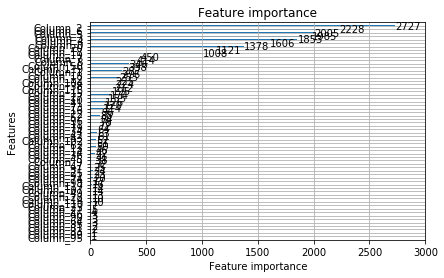

In [13]:
# Plot importance
lgb.plot_importance(gbm)
plt.show()

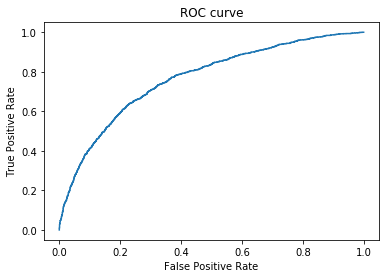

0.7655


In [14]:
%matplotlib inline
from sklearn import metrics as mtr
from matplotlib import pyplot as plt
from sklearn import metrics

y_pred = gbm.predict(X_test)

# AUC (Area Under the Curve) を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

#prob = model.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = mtr.roc_curve(y_test, prob,pos_label =1)

plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print( '%.4f' %auc)

In [15]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.4f}'.format(
      average_precision))

Average precision-recall score: 0.6806


In [17]:
from sklearn.metrics import average_precision_score

#average_precision["micro"] = average_precision_score(y_test, y_pred,
#                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(average_precision["micro"]))

#PR曲線が書きたい。。
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, alpha=0.2,
         where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2,
 #                color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format())

IndexError: invalid index to scalar variable.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.6806')

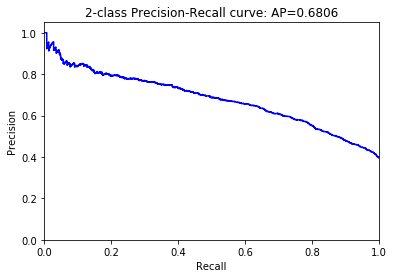

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=1,        where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2,
#                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(
          average_precision))

In [19]:
from sklearn import metrics as mtr
# 3.まとめ（精度計算）

#print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,y_pred))
print('テストデータに対する roc-auc： %.4f' %mtr.roc_auc_score(y_test, y_pred))
print('テストデータに対する log-loss： %.4f' %mtr.log_loss(y_test, y_pred))

テストデータに対する roc-auc： 0.7655
テストデータに対する log-loss： 0.5628


In [20]:
def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()

      0         1
0   1.0  0.936496
1   1.0  0.921462
2   1.0  0.916897
3   1.0  0.911132
4   1.0  0.910188
5   1.0  0.906607
6   1.0  0.906344
7   1.0  0.904634
8   1.0  0.904215
9   1.0  0.902435
10  1.0  0.900171
11  1.0  0.896958
12  0.0  0.896624
13  1.0  0.896451
14  1.0  0.894033
15  1.0  0.893533
16  1.0  0.893380
17  1.0  0.890770
18  1.0  0.890666
19  1.0  0.888791


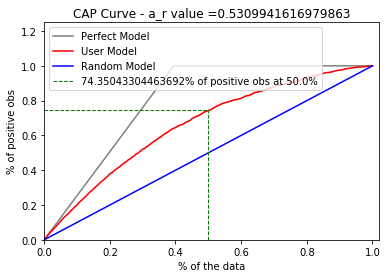

In [21]:
from scipy import integrate
y_pred_proba = gbm.predict(X_test)

capcurve(y_values=y_test, y_preds_proba=y_pred_proba)

https://github.com/APavlides/cap_curve/blob/master/cap_curve.py

In [22]:
df_pre = pd.read_csv("data.csv")
df_train = pd.Series(df_pre.objective_variable, name='objective_variable')
df_train = pd.DataFrame(df_train)

In [23]:
df_train['employee_id'] = df_pre['employee_id']

In [30]:
df_train.any()

objective_variable    True
employee_id           True
dtype: bool

In [32]:
y_pr = gbm.predict(X)

In [41]:
df_interview.shape

(7675, 3)

In [34]:
df_train['score'] = y_pr

In [38]:
df_test = df_train[df_train['objective_variable'] == 1]

In [40]:
df_interview = df_train[df_train['objective_variable'] == 0]

In [42]:
df_interview.to_csv('cancel_to_csv_out.csv')

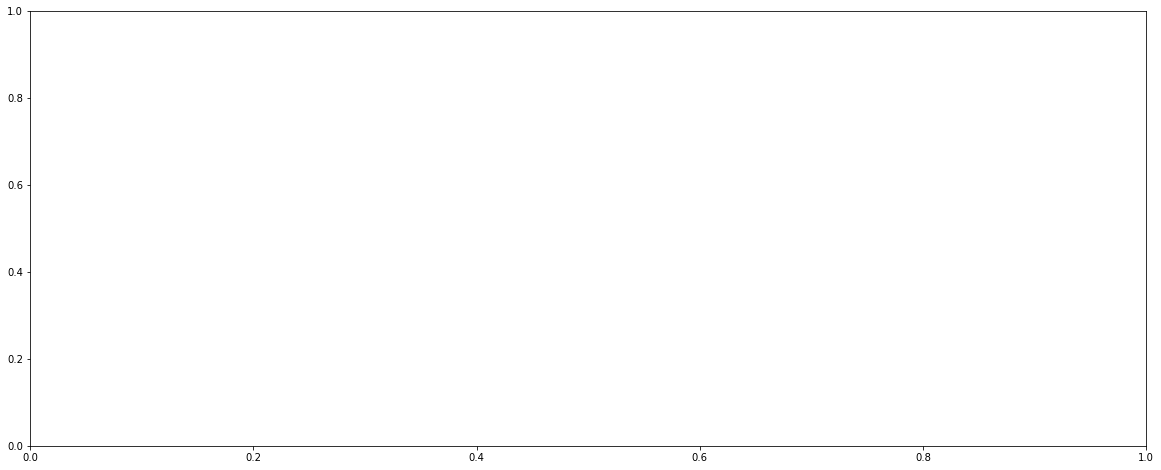

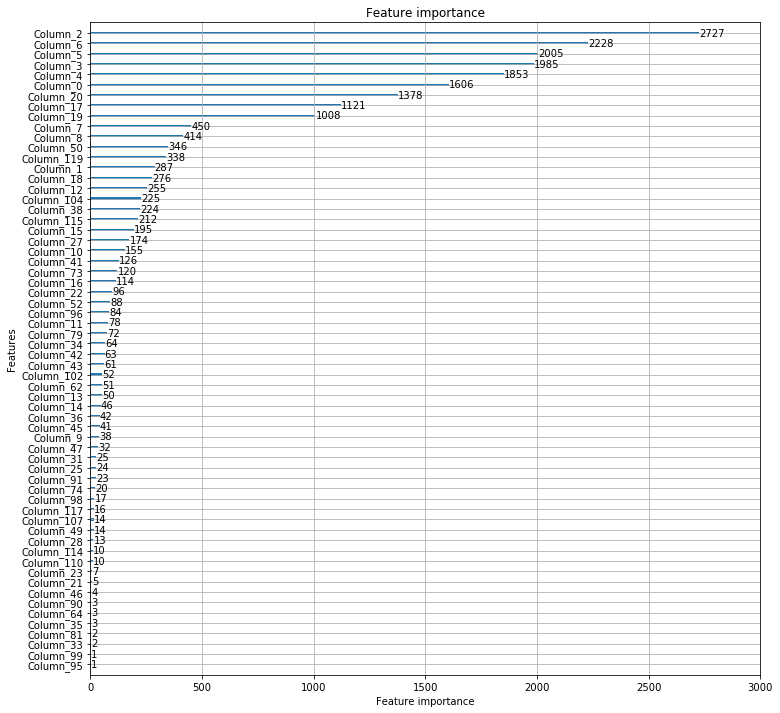

In [22]:
lgb.plot_importance(gbm, figsize=(12, 12))
plt.show()

Plot feature importances...


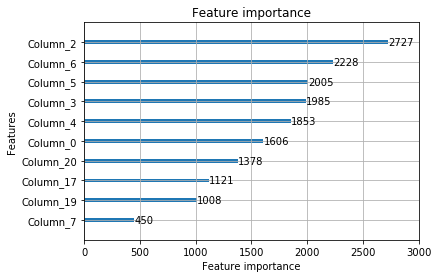

In [19]:
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

In [21]:
print('Plot 84th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
plt.show()

Plot 84th tree...


ImportError: You must install graphviz to plot tree.

In [23]:
df_train.head()

,age,gender,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,DSP,SEO,twitter広告,その他,アフィリエイト,メルマガ,リスティング,提携媒体,GDN,GoogleMap,Google検索,KWターゲティング,LINE,TOP埋め込みEF,YDN,Yahoo検索,docomo,null,useful下部固定,webもり,アクセストレード,アフィリエイトB,キャリアパーク,フォロワーターゲティング,プレスコ,プロモツイート,メディパートナー,リマーケティング,...,infeed_remarketing,infeed_インタレストマッチ,infeed_ターゲティング,null,こだわり軸,セミナー,ターゲティング,ターゲティング_remarketing,ターゲティング_インタレストマッチ,ハローワーク軸,フォロワーターゲティング,フリーター軸,ミドルワード軸,メルマガ_登録半年以内_アプローチ+面談日程連絡待ち_求人紹介_転職無し,メルマガ_登録半年以内_アプローチ_ハタラクティブ魅力付け,メルマガ_登録半年以内_面談済み_就活ノウハウ_就活準備,メルマガ_登録半年以内_面談済み_求人紹介_残業無し推し,メルマガ_登録半年以前_面談済み_就活ノウハウ_就活全体,メルマガ_登録半年以前_面談済み_求人紹介_転職無し,メルマガ_面談済み_応募意思あり_CCテキストよびかけ,リターケティング,リマーケティング,友達紹介カード,地域軸,地域軸_未経験,大卒軸,就職軸_学歴KW軸,属性軸,属性軸_フリーター軸,属性軸_大卒軸,属性軸_既卒軸,属性軸_第二新卒軸,属性軸_高卒軸,手動プレースメント,指名検索軸,支援軸,既卒軸,正社員軸,相談軸,第二新卒軸,職種軸,自動プレースメント,自動メール_登録10日後経過面談未予約_カウンセラー紹介,自動メール_登録7日後経過面談未予約_就職成功事例紹介,興味関心ターゲティング,転職軸,雇用形態軸,面談,高卒軸,SP
0,24.0,1,4,0,5,3,8,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,19.0,0,2,1,0,0,32,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,21.0,0,3,3,8,2,24,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,24.0,0,5,5,0,0,8,0,1,0,0,0,1,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21.0,1,1,1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
